### Imports

In [1]:
import os
from pathlib import Path
import time
from dataclasses import dataclass
from typing import Optional
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# DICL
from dicl import dicl, adapters
from dicl.icl import iclearner as icl
from dicl.utils.main_script import (
    load_moment_model,
    load_moirai_model,
)

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

## Arguments

In [2]:
@dataclass
class Args:
    is_fine_tuned: bool = False
    forecast_horizon: int = 96
    model_name: str = "AutonLab/MOMENT-1-small"  # f"Salesforce/moirai-1.1-R-large"
    context_length: int = 512
    dataset_name: str = "ETTh1"  # Will be set based on forecast_horizon
    adapter: Optional[str] = None  # "pca"
    data_path: Path = Path("/mnt/vdb/abenechehab/dicl-adapters/results/data.csv")
    seed: int = 13
    device: str = "cpu"
    logger_name: str = "DICL Adapter"
    log_level: str = "INFO"
    log_dir: Path = Path("/mnt/vdb/abenechehab/dicl-adapters/logs")
    number_n_comp_to_try: int = 4
    inference_batch_size: int = 512
    supervised: bool = False

args = Args()

## Data

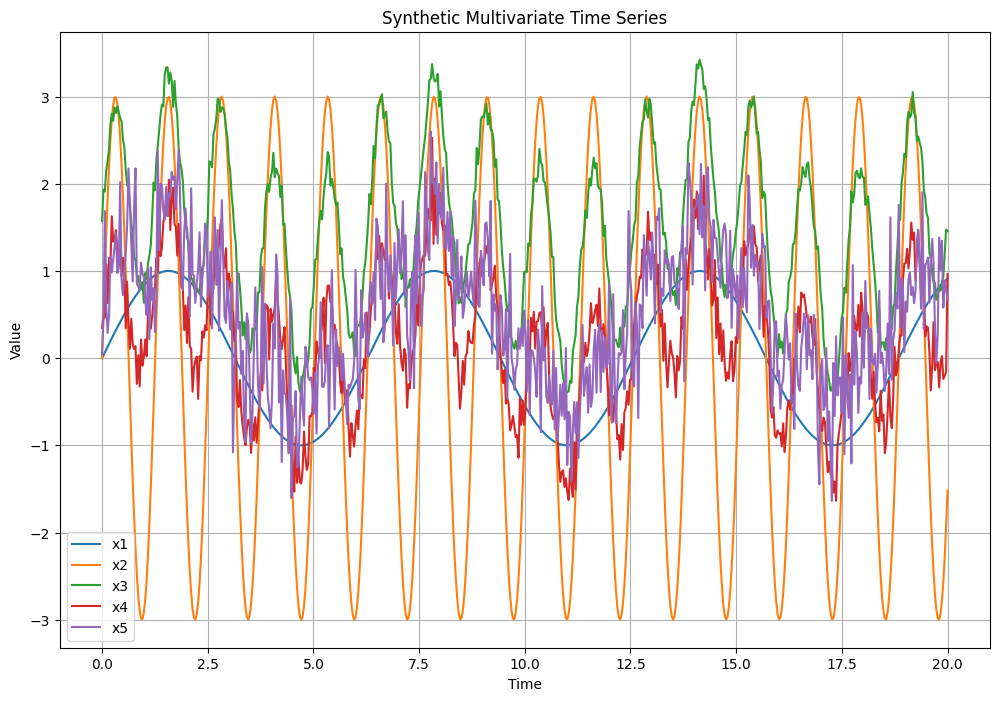

,x1,x2,x3,x4,x5,time
0,0.000000,0.000000,1.572569,0.347167,0.049073,0.000000
1,0.032943,0.492001,1.932249,0.488508,0.448456,0.032949
2,0.065850,0.970680,1.912484,0.463667,1.686464,0.065898
3,0.098686,1.423072,2.152031,1.078427,0.594821,0.098847
4,0.131414,1.836929,2.259292,0.632163,0.288987,0.131796


In [3]:
# Parameters
n_timesteps = args.context_length + args.forecast_horizon
xtime = np.linspace(0, 20, n_timesteps)

# Generate multivariate time series
x1 = np.sin(xtime)  # Base signal
# x2 = 0.7 * np.sin(0.35 * xtime)  # Uncorrelated with x1
x2 = 3.0 * np.sin(5.0 * xtime)
x3 = 0.6 * x1 + 0.4 * x2 + 1.5 + np.random.normal(0, 0.1, n_timesteps)
x4 = 0.7 * x1 + 0.3 * x2 + 0.2 + np.random.normal(0, 0.2, n_timesteps)
x5 = 0.9 * x1 + 0.1 * x2 + 0.5 + np.random.normal(0, 0.5, n_timesteps)


# x3 = np.sin(xtime - np.pi / 4)  # Lagged version of x1
# x4 = x1**2  # Nonlinear transformation of x1

# Combine into a DataFrame for visualization and analysis
multivariate_ts = pd.DataFrame(
    {"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "time": xtime}
)

# Plot the time series
plt.figure(figsize=(12, 8))
for col in ["x1", "x2", "x3", "x4", "x5"]:
    plt.plot(multivariate_ts["time"], multivariate_ts[col], label=col)
plt.title("Synthetic Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

# Display a few rows of the dataset
multivariate_ts.head()

In [4]:
time_series = np.expand_dims(multivariate_ts[['x1', 'x2', 'x3', 'x4', 'x5']].values, axis=0)
time_series = time_series.swapaxes(1, 2)

X_test = copy.copy(time_series[:, :, :-args.forecast_horizon])
y_test = copy.copy(time_series[:, :, -args.forecast_horizon:])
X_train, y_train = copy.copy(X_test), copy.copy(y_test)

n_features = time_series.shape[1]

## DICL

In [52]:
# df = pd.DataFrame()
df1 = pd.DataFrame()

In [ ]:
adapter_list = [None, 'pca', 'rand', 'linearAE'] # 'svd'
n_seeds = 5
for adapter in adapter_list:
    for _ in range(n_seeds):
        seed = np.random.randint(0, 1000)
        np.random.seed(seed)
        torch.manual_seed(seed)

        for n_components in range(1 if adapter else 5, 6):
            model_loaded = False
            if (not model_loaded) or args.is_fine_tuned:
                model_loaded = True
                if "MOMENT" in args.model_name:
                    model = load_moment_model(args.model_name, args.forecast_horizon).to(
                        torch.device(args.device)
                    )
                    icl_constructor = icl.MomentICLTrainer
                elif "moirai" in args.model_name:
                    model = load_moirai_model(
                        args.model_name, args.forecast_horizon, args.context_length
                    ).to(torch.device(args.device))
                    icl_constructor = icl.MoiraiICLTrainer
                elif "ttm" in args.model_name:
                    raise NotImplementedError("TTM backbone not implemented yet")
                else:
                    raise ValueError(f"Not supported model: {args.model_name}")

            disentangler = adapters.MultichannelProjector(
                num_channels=n_features,
                new_num_channels=n_components,
                patch_window_size=None,
                base_projector=adapter,
                device=args.device,
            )

            iclearner = icl_constructor(
                model=model,
                n_features=n_components,
                forecast_horizon=args.forecast_horizon,
            )

            DICL = dicl.DICL(
                disentangler=disentangler,
                iclearner=iclearner,
                n_features=n_features,
                n_components=n_components,
            )

            next_time_cp = time.time()
            if args.supervised:
                # assert not args.is_fine_tuned, "iclearner must be frozen when adapter is "
                # "(supervised) fine-tuned"
                DICL.adapter_supervised_fine_tuning(
                    X=X_train,
                    y=y_train,
                    device=args.device,
                )
            else:
                DICL.fit_disentangler(X=X_test)

            if args.is_fine_tuned:
                DICL.fine_tune_iclearner(
                    X=X_train,
                    y=y_train,
                    n_epochs=1,
                    batch_size=8,
                    learning_rate=1e-4,
                    max_grad_norm=5.0,
                    verbose=1,
                    seed=args.seed,
                )
                next_time_cp = time.time()

            _, _, _, _ = DICL.predict_multi_step(
                X=time_series,
                prediction_horizon=args.forecast_horizon,
                batch_size=args.inference_batch_size,
            )
            next_time_cp = time.time()

            metrics = DICL.compute_metrics()

            df1 = pd.concat([df1, pd.DataFrame([{
                    'adapter': adapter,
                    'n_components': n_components,
                    'seed': seed,
                    **metrics
                }])], 
                ignore_index=True
            )
            if not adapter:
                df1 = pd.concat(
                    [
                        df1,
                        pd.DataFrame(
                            [
                                {
                                    "adapter": adapter,
                                    "n_components": 1,
                                    "seed": seed,
                                    **metrics,
                                }
                            ]
                        ),
                    ],
                    ignore_index=True,
                )

/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
feature: 100%|██████████| 5/5 [00:00<00:00, 40.48it/s]
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise

In [50]:
import seaborn as sns

def plot_df(df, metric):
    # Get baseline (no adapter) result
    df["adapter"] = df["adapter"].fillna("no_adapter")
    # baseline_mse = df[df["adapter"] == "no_adapter"][metric].values.mean()

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x="n_components",
        y=metric,
        hue="adapter",
        style="adapter",
        marker="o",
    )
    # plt.axhline(y=baseline_mse, color="grey", linestyle="--", label="No adapter")
    plt.title('MSE vs Number of Components')
    plt.grid(True)
    plt.show()

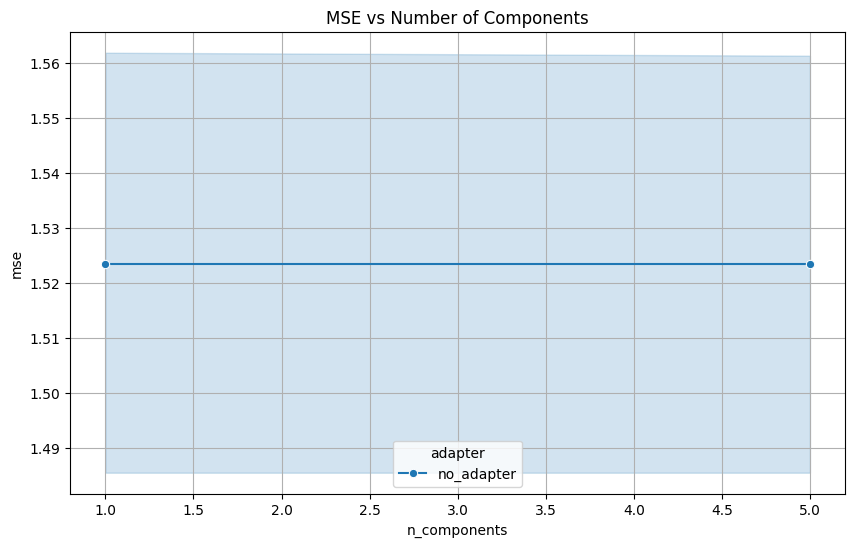

In [51]:
# plot_df(df=df, metric='mse')
plot_df(df=df1, metric="mse")

In [23]:
df1

,adapter,n_components,seed,mse,mae,scaled_mse,scaled_mae
0,no_adapter,5,202,1.566072,0.967258,1.114803,0.891297
1,no_adapter,5,915,1.615309,0.988295,1.138388,0.909122
2,no_adapter,5,990,1.523145,0.948394,1.079549,0.875094
3,no_adapter,5,856,1.594163,0.970754,1.113281,0.894182
4,no_adapter,5,911,1.492470,0.930787,1.018827,0.852202
